<a href="https://colab.research.google.com/github/minjeon99/ESAA-10th-OB/blob/Week3/w3_mon_study_ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stacked Regressions to predict House Prices**

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn


from scipy import stats
from scipy.stats import norm, skew


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# 삭제 전 Id 칼럼 값 저장
train_ID = train['Id']
test_ID = test['Id']

# Id 칼럼 drop
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# 바뀐 shape
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## **Data Processing**

### **Outliers**

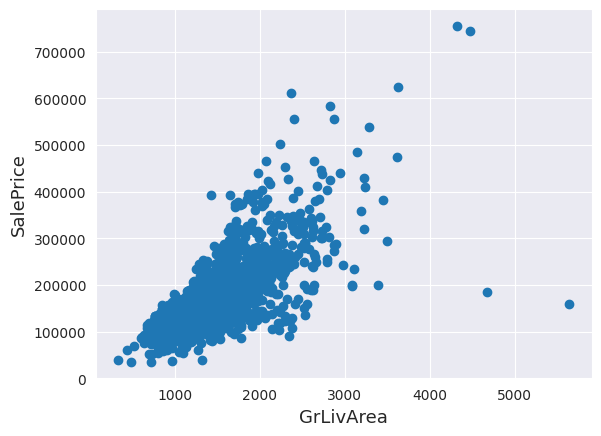

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

- 오른쪽 아래 2개 values: extremely large GrLivArea that are of a low price
  
  => outliers

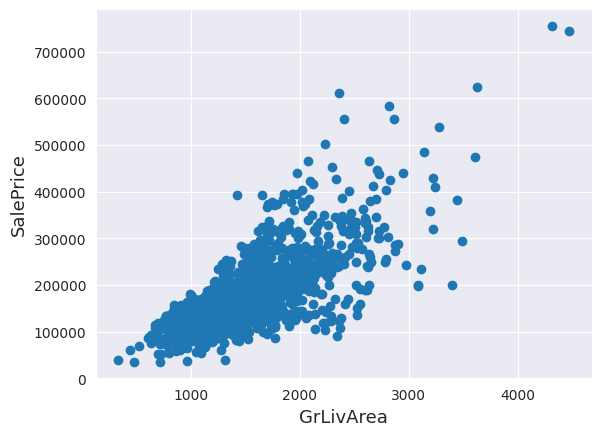

In [8]:
# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

- 삭제된 모습
- 이상치 제거가 항상 안전한 것은 아님. 이 경우 매우 극단적인 값이기 때문에 삭제한 것
  - 테스트 데이터의 모든 이상치를 제거하면 모델에 안 좋은 영향을 미칠 수 있음
  - 모든 이상치를 제거하는 대신, 일부 모델을 이상치에 대해 견고하게 만들 것임

### **Target Variable**

- **`SalePrice`**: target varible


 mu = 180932.92 and sigma = 79467.79



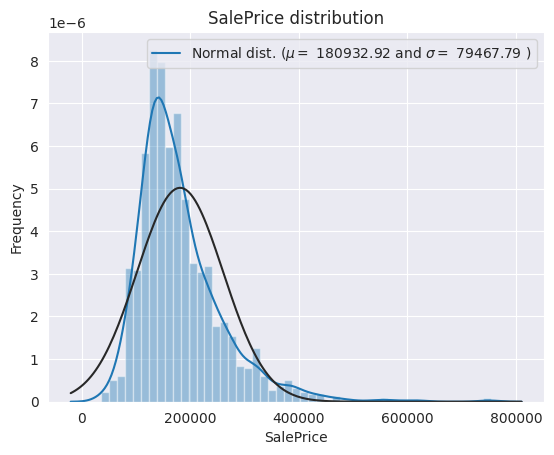

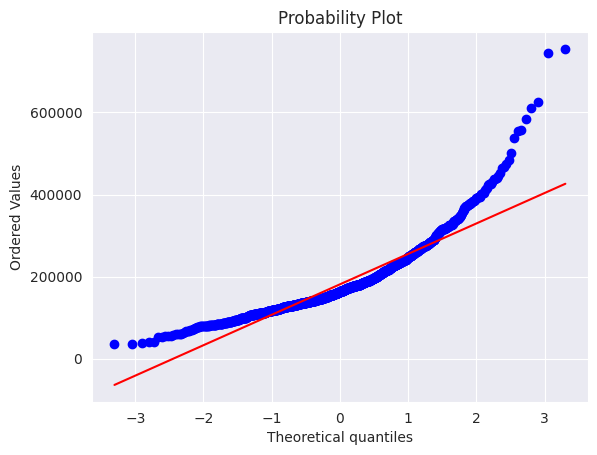

In [10]:
sns.distplot(train['SalePrice'] , fit=norm)

# fitted parameters
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- right skewed
  - (linear) models love normally distributed date => transform this variable, make it more normally distributed

**Log-transformation of the target variable**


 mu = 1.27 and sigma = 0.01



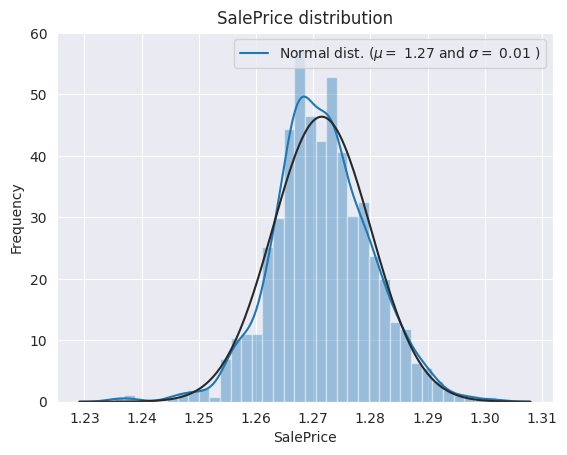

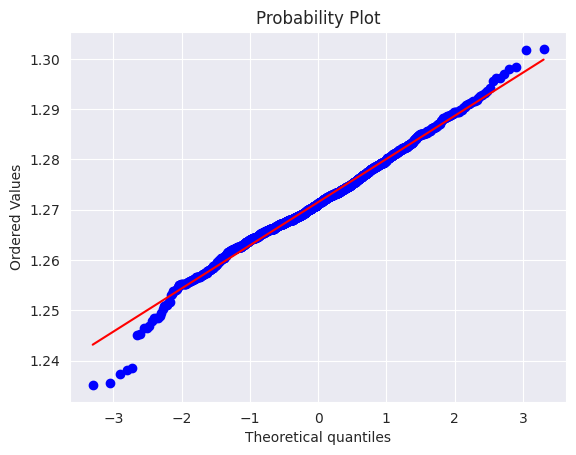

In [14]:
train["SalePrice"] = np.log1p(train["SalePrice"])

# new distribution
sns.distplot(train['SalePrice'], fit=norm);

# get the fitted parameters
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Q-Q plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- skew: 사라짐
- more normally distributed

### **Features engineering**

In [15]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


**Missing Data**

In [18]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

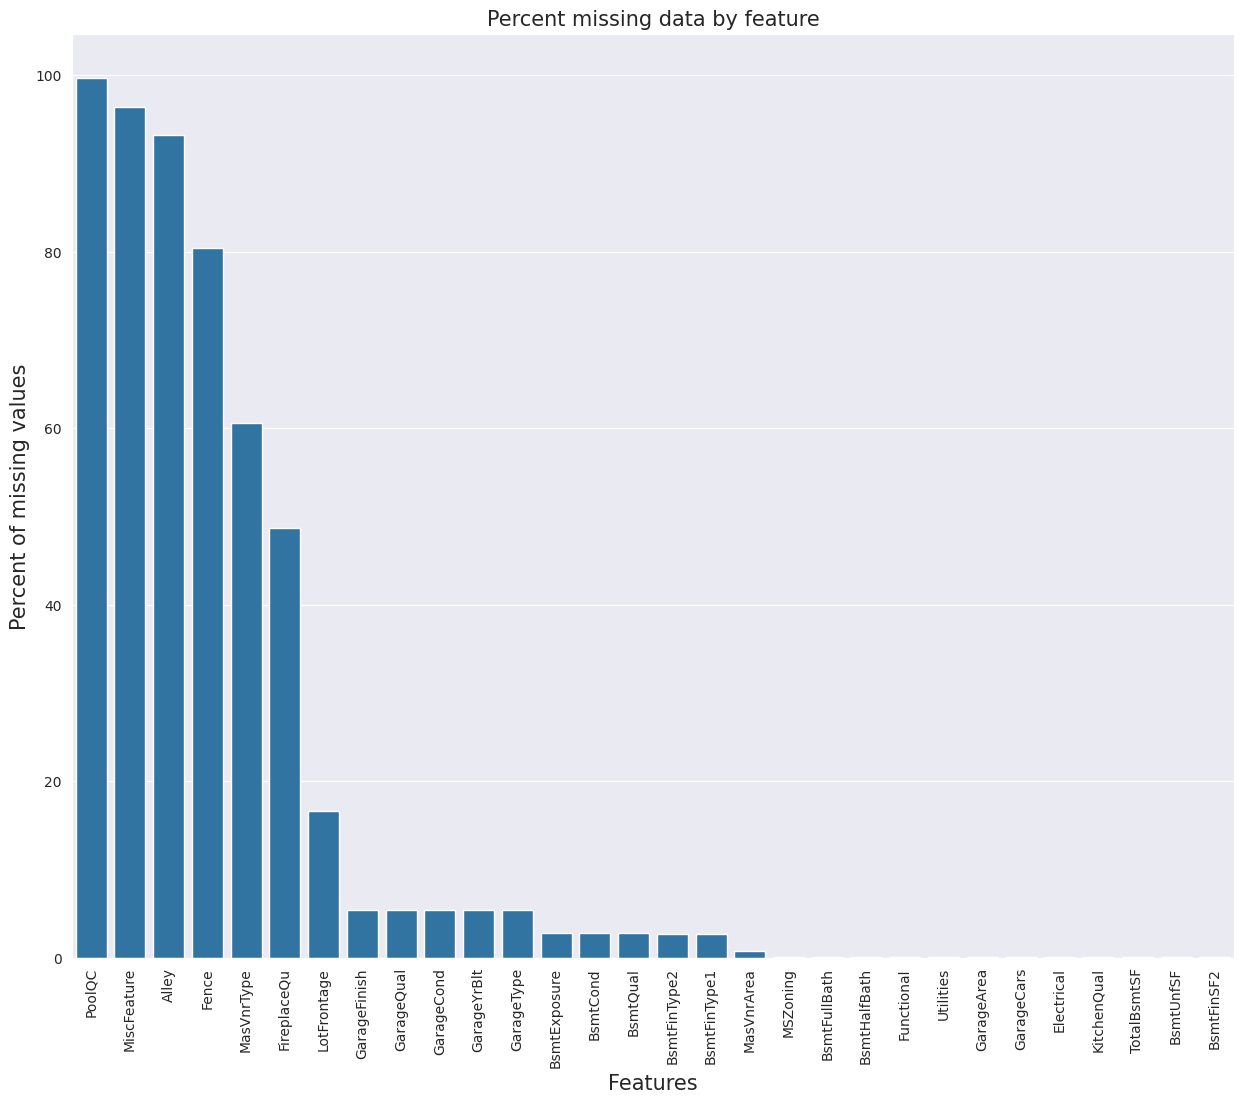

In [20]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

- 대부분이 결측치인 컬럼도 존재

**Data Correlation**

<Axes: >

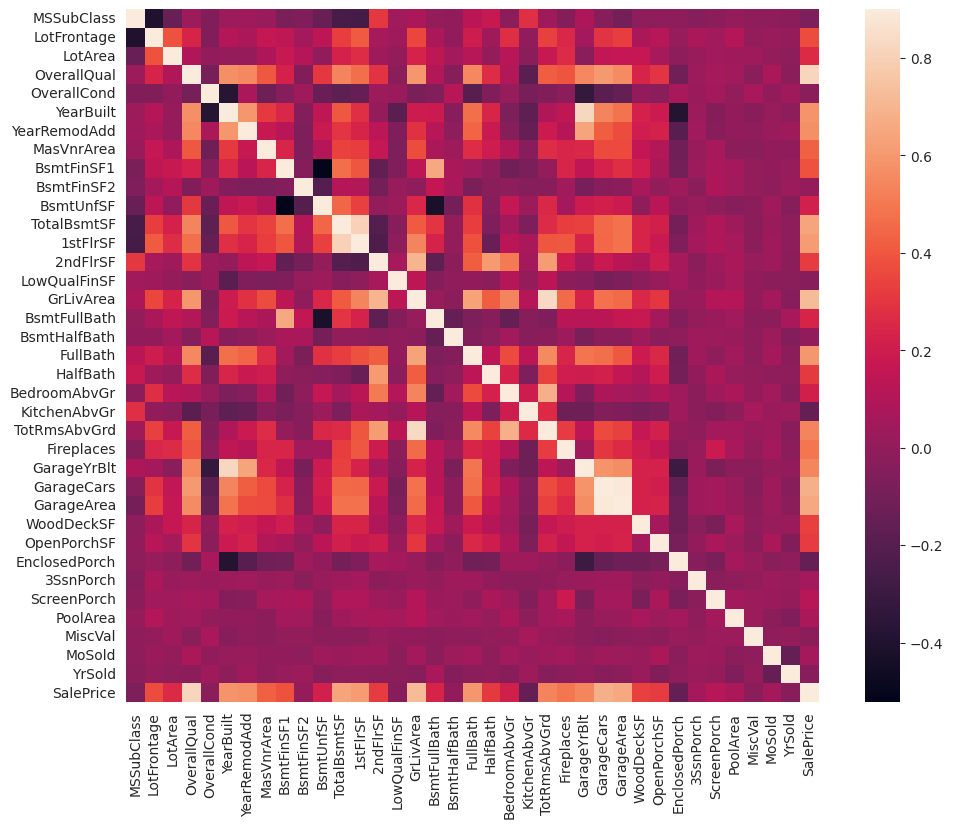

In [22]:
corrmat = train.corr(numeric_only=True)
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

**Imputing missing values**

- **`PoolQC`**: Na means "No Pool"

In [23]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

- **`MiscFeature`**: Na means "No misc feature"

In [24]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

- **`Alley`**: Na means "No alley access"

In [25]:
all_data['Alley'] = all_data['Alley'].fillna('None')

- **`Fence`**: Na means "No fence"

In [26]:
all_data['Fence'] = all_data['Fence'].fillna('None')

- **`FireplaceQu`**: Na means "No fireplace"

In [27]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

- **`LotFrontage`**: 주변 지역의 다른 주택과 비슷한 면적일 가능성 높음 => median LotFrontage of the neighborhood로 채우기

In [28]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **`GarageType`**, **`GarageFinish`**, **`GarageQual`**, **`GarageCond`**: "None"으로 채우기

In [29]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **`GarageYrBlt`**, **`GarageArea`**, **`GarageCars`**: 0으로 대체 (No garage = No cars in such garage)

In [30]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **`BsmtFinSF1`**, **`BsmtFinSF2`**, **`BsmtUnfSF`**, **`TotalBsmtSF`**, **`BsmtFullBath`**, **`BsmtHalfBath`**: 지하실이 없기 때문에 결측치=0일 가능성 높음

In [31]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **`BsmtQual`**, **`BsmtCond`**, **`BsmtExposure`**, **`BsmtFinType1`**, **`BsmtFinType2`**: NaN means "No basement"

In [32]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **`MasVnrArea`**, **`MasVnrType`**: 결측치 = "No masonry veneer"일 가능성 높음

In [33]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **`MSZoning`**: 최빈값 'RL'로 대체

In [34]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **`Utilities`**
  - 1개의 "NoSeWa"
  - 2개의 NA
  - 나머지 모든 record가 "AllPub"

  => 열 drop

In [35]:
all_data = all_data.drop(['Utilities'], axis=1)

- **`Functional`**: NA means "typical"

In [36]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **`Electrical`**
  - 1개의 NA
  - 최빈값 'SBrkr'로 대체

In [37]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **`KitchenQual`**
  - 1개의 NA
  - 최빈값 'TA'로 대체

In [38]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **`Exterior1st`**, **`Exterior2nd`**
  - 1개의 NA
  - 최빈값로 대체

In [39]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **`SaleType`**: 최빈값 "WD"로 대체

In [40]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **`MSSubClass`**: Na="No building class"일 가능성 높음

In [41]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [42]:
# 결측치 재확인

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


- 결측치 X

**실제로는 categorical인 numeric varibles => transforming**

In [46]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

all_data['OverallCond'] = all_data['OverallCond'].astype(str)

all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**ordering set => Label Encoding**

In [47]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


**파생변수 생성**
- 주택 가격 예측에 area related features는 매우 중요하므로, **`total area`** 변수 추가

In [48]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**skewed features**

In [49]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check skew
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


**(highly) skewed features => Box Cox Transformation**
- scipy의 **`boxcox1p`** 사용
- λ=0 -> **`log1p`**와 동일

In [51]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


**categorical features -> dummy variables**

In [52]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


- 만들어진 train/tet sets

In [53]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## **Modeling**

In [54]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

- **`cross_val_score`** 사용 & shuffle 기능 추가한 함수 정의

In [55]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### **Base models**

- Lasso Regression
  - 이상치에 민감한 모델이기 때문에, sklearn의 **`Robustscaler()`** 사용
    - Scaled Value = Value−Median / IQR
    - 중앙값과 qunatiles를 사용하므로 이상치의 영향이 적음

In [56]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- Elastic Net Regression
  - 마찬가지로 **`RobustScaler()`**적용

In [57]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- Kernel Ridge Regression
  - 비선형 데이터에 적합 O
  - 비모수 추정 기법: 정규성 가정 X

In [58]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- Gradient Boosting Regression
  - **huber**:  L1 loss와 L2 loss의 단점 보완, 장점 취함
    - 미분 가능하면서 outlier에 영향을 덜 받는 일차식에 가까운 형태

In [60]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

- XGBoost

In [61]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, random_state =7, nthread = -1)

- LightGBM

In [62]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

**Base models scores**

In [63]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0032 (0.0002)



In [64]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0031 (0.0002)



In [65]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.0031 (0.0001)



In [66]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.0026 (0.0002)



In [67]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.0086 (0.0003)



In [68]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

### **Stacking models**

#### **1. Simple Stacking Approach: Averaging base models**

**Averaged base models class**

In [70]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # origina models의 복제본
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # train
        for model in self.models_:
            model.fit(X, y)

        return self

    # predict
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

**Averaged base models score**

In [71]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso)) # 4개의 모델 사용

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0027 (0.0002)



#### **2. Adding a Meta-model**

- averaged base models에 meta model 추가
- base models의 예측을 meta model train에 사용
- procedure
  1. total training set -> 2개의 세트로 분할(train, holdout)
  2. train으로 base models 학습
  3. holdout으로 base model을 테스트
    - 이 때의 예측 = out-of-folds predictions
  4. out-of-folds predictions을 input으로, target variable을 output으로 meta model 학습
  - 1~3 과정을 반복적으로 수행
    - ex. 5-fold stacking: training data를 5 folds로 분할 -> 5번 반복
  - prediction part: 모든 base models 예측의 평균값
  - final prediction: meta model로 수행

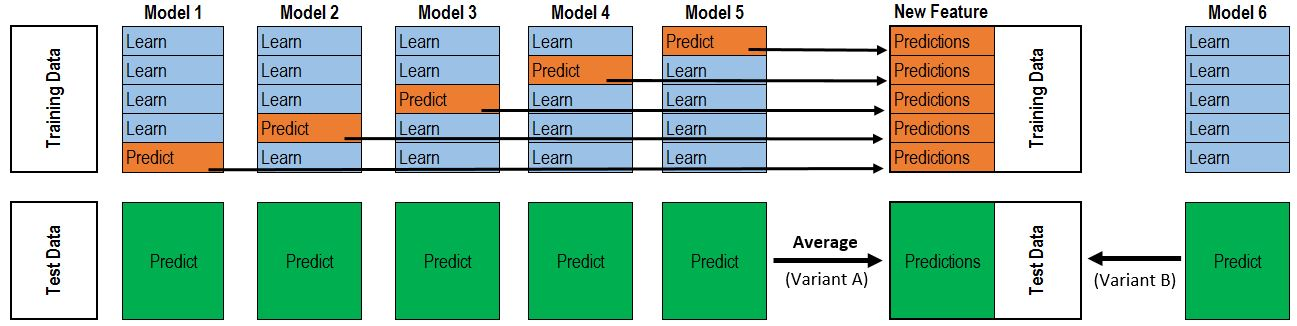

**Stacking averaged Models Class**

In [72]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    #Do the predictions of all base models on the test data and use the averaged predictions as
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

In [73]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), # 3개의 모델 사용
                                                 meta_model = lasso) # meta model: Lasso

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0026 (0.0002)


### **Ensembling StackedRegressor, XGB and LGBM**

In [74]:
# rmsle evaluation function

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#### **Final Training and Prediction**

- StackedRegressor

In [75]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0017198105385940118


- XGBoost

In [76]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.008601202109919121


- LightGBM

In [77]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

- RMSLE on the entire Train data when averaging

In [78]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.002365707348022781


- Ensemble prediction

In [79]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15